<h1>Using Machine Learning to Classify Apples and Oranges in Unseen Images</h1>

<h2>Benjamin Andrews</h2>

<h3>Problem statement</h3>
Develop a model that is able to tell apart unseen photographs of apples and oranges, using machine learning methods.

In this project, we will implement and compare the performance of five machine learning algorithms for predicting the fruit present in images that they have never seen before.

<h3>Description of data</h3>
We will use the following dataset from Kaggle:
https://www.kaggle.com/datasets/kipshidze/apple-vs-orange-binary-classification

The dataset contains 399 images of apples and 399 images of oranges. Each image is a 128x128 pixel .jpeg. Among the photos are images containing multiple fruits, fruits on trees, illustrations, chopped fruits and fruits with unusual colours - we will aim to be able to classify images of these kinds, which makes the task more challenging.

<h3>Method overview</h3>

<h5>Transforming the images into numerical data</h5>
We will start by transforming the images into numerical data for analysis. The idea will be to use the red, green and blue values of each pixel (three values between 0 and 255) as the design matrix X for machine learning.

If we use this method as-is, this will result in collecting 49152 independent variables, which is an unnecessarily large amount, and would lead to slow processing and possible overfitting to fine details of the images.

To mitigate these issues, we will:
<ul>
    <li>Reduce each image to size 32x32;</li>
    <li>Use PCA (Principal Components Analysis) to reduce the number of variables further.</li>
</ul>

Reducing the size of the images to 32x32 will decrease the number of pixels sixteen-fold, and using PCA will allow us to further reduce the number of independent variables. Reducing the number of variables will decrease the learning time and result in a simpler model, and using PCA should further help avoid overfitting to unimportant fine details in the images.

<h5>Classification methods</h5>

We will implement five machine learning methods:

<ol>
    <li>Logistic regression;</li>
    <li>Decision trees;</li>
    <li>Random forests;</li>
    <li>Support Vector Machines;</li>
    <li>k-Nearest Neighbours.</li>
</ol>

Random forests are generally considered to be the standard for image classification problems, but we will implement and compare the performance of each of these models using Python with scikit-learn.

We will evaluate each of the models using cross validation. We will split the data into five parts, and train the model five times, setting aside a different fifth of the data for testing each time. The average performance of the model (the proportion of correct predictions on the unseen test data) over the five trials will be considered as the metric for the model's performance.

<h3>Preparing and preprocessing the data</h3>

We start off by importing the data. The data can be found in the fruit_data.zip zipped folder; we extract the folder to this JupyterLab workspace below.

In [24]:
import zipfile
import os

# Unzip the uploaded file and extract it to the "dataset" folder in this workspace.
with zipfile.ZipFile("fruit_data.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

# Check the contents of the "dataset" folder.
os.listdir("dataset")

['orange', 'apple']

The dataset folder contains two folders, one named `apple` with 399 images of apples, and one named `orange` with 399 images of oranges. Let's prepare to access them.

In [25]:
# Get the working directory of this Jupyter environment.
here = os.getcwd()

# We set source_0 and source_1 to be the source folders for the apples and oranges, respectively.
source_0 = os.path.join(here, "dataset", "apple")
source_1 = os.path.join(here, "dataset", "orange")

# We confirm that the folders exist by listing a few of their files.
print("Apple files:", os.listdir(source_0)[:5])
print("Orange files:", os.listdir(source_1)[:5])

Apple files: ['150.jpeg', '347.jpeg', '071.jpeg', '284.jpeg', '072.jpeg']
Orange files: ['150.jpeg', '347.jpeg', '071.jpeg', '284.jpeg', '072.jpeg']


Now it's time to begin processing the data!

In [26]:
from PIL import Image
import numpy as np
import pandas as pd

image_size = (32, 32)

"""
A function for converting images to normalised RGB pixel values.
The function uses the Image.convert("RGB") method from PIL Image to convert the image to the numerical
red, green and blue values for each pixel. We re-size the image to 32x32 using resize(image_size).

We then load the data into a numpy array using np.asarray(img).astype(np.float32), and divide by 255
so that we have values between 0 and 1 rather than between 0 and 255.

We use .flatten() to turn the resulting values into a 1D array, rather than a multi-dimensional one
(the data is loaded as a 2D array corresponding to where pixels are on the image, but we do not want
this).
"""
def load_and_flatten_image(path):
    img = Image.open(path).convert("RGB").resize(image_size)
    img_array = np.asarray(img).astype(np.float32) / 255  # Normalize RGB pixel values, which span from 0 to 255, to be in [0,1].
    return img_array.flatten()

X = []
y = []

"""
We set up the design matrix X and target vector y.

We start with empty lists, and then, for each image, add the RGB pixel data (independent variables)
to X, and the class (0 for apple or 1 for orange) to y. We iterate through every jpeg image in the
folders. (The '.jpg' option is included to make sure there is no data missed)
"""
for file in os.listdir(source_0):
    if file.lower().endswith((".jpg", ".jpeg")): # Ensure that it only reads jpegs.
        X.append(load_and_flatten_image(os.path.join(source_0, file))) # Add the reduced RGB values to the input data X.
        y.append(0) # Add 0 to classes y.

for file in os.listdir(source_1):
    if file.lower().endswith((".jpg", ".jpeg")):
        X.append(load_and_flatten_image(os.path.join(source_1, file)))
        y.append(1)

# Turn the data into pandas dataframe and series for use with scikit-learn.
X = pd.DataFrame(X)
y = pd.Series(y)

<h5>Shape of the data</h5>

We have set up a design matrix `X` with 3072 variables worth of information about each image (three values for each of the 1024 pixels of the image) and a vector `y` with 0's and 1's, stating whether each image is of an apple (0) or an orange (1). Below, you can see a sample of the design matrix `X`. The target vector `y` simply contains 399 0's and then 399 1's, since we added all the data for the apples first.

In [27]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print(X.head())

X shape: (796, 3072)
y shape: (796,)
       0         1         2         3         4         5         6     \
0  0.317647  0.341176  0.180392  0.576471  0.741176  0.294118  0.678431   
1  0.803922  0.815686  0.894118  0.874510  0.886275  0.937255  0.925490   
2  0.662745  0.564706  0.450980  0.650980  0.533333  0.450980  0.407843   
3  0.254902  0.360784  0.180392  0.243137  0.372549  0.078431  0.282353   
4  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

       7         8         9     ...      3062      3063      3064      3065  \
0  0.925490  0.435294  0.572549  ...  0.450980  0.980392  0.972549  0.807843   
1  0.945098  0.984314  0.745098  ...  0.803922  0.831373  0.792157  0.792157   
2  0.376471  0.333333  0.372549  ...  0.117647  0.419608  0.152941  0.129412   
3  0.415686  0.066667  0.278431  ...  0.858824  0.584314  0.662745  0.800000   
4  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   

       3066      3067      3068

As we alluded to in the introduction, 3072 variables is far too many - we will use principal components analysis to reduce the data to 50 components. PCA analyses the design matrix `X` and tries to summarise the significant features of `X`, often observed over many variables together, as a smaller number of variables.

We will also normalise the pixel data, so that each of the pixel colour values has mean 0 and variance 1 (individually for each pixel), to prevent the models from weighing some pixels artifically more heavily than others.

Throughout our code, we will use `random_state = 1` in machine learning methods. Using a fixed random state allows for reproducibility, as it means the same outcome is obtained each time from a method featuring randomness, by seeding the random number generator. We will use 1 as our random_state, but 42 is also commonly used in machine learning.

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalize the individual pixel data.
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply Principal Component Analysis to X.
pca = PCA(n_components=50, random_state=1)
X = pca.fit_transform(X)
X = pd.DataFrame(X)

We can now see that `X` features only 50 independent variables.

In [29]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print(X.head())

X shape: (796, 50)
y shape: (796,)
          0          1          2         3         4          5          6   \
0  10.819189  -4.094946   1.094188  7.962549  7.674477  15.128052  -2.626755   
1 -22.104288   9.020690  14.422350 -1.345590  3.026566  13.609210  -2.120220   
2  25.667652   5.107093  -7.272169 -5.018911  5.049267   2.034111   8.861507   
3  31.361917  17.030600 -14.387694  6.174854  4.389697  13.266327 -15.717709   
4 -51.675972   6.457839 -12.517532  5.206092 -3.920796  17.953018  -3.341000   

         7         8         9   ...        40        41        42        43  \
0 -2.583377 -6.929609 -1.828638  ...  0.785811 -5.783383 -3.220324 -0.110696   
1  1.378266  2.096532  7.240226  ... -0.017405 -1.862282  0.246571 -4.645911   
2 -5.574120 -2.114997  4.524931  ... -4.565657  2.344640 -2.016979 -1.917758   
3  7.961188 -1.480742 -5.894461  ...  0.282642  0.128683  1.466573  0.290232   
4 -2.503030 -2.115030 -0.639614  ... -1.921150  1.384737  0.689214  0.293503   

   

<h3>Machine learning algorithms</h3>

<h5>Logistic regression</h5>
To begin with, let's set up a baseline model and see it in action. We will implement logistic regression, an algorithm similar to linear regression, but generalised to estimate probabilities that the mystery data point belongs to class 0 and class 1.

Firstly, we split the data into a training set (80% of the data) and a testing set (the other 20%). We then train a Logistic Regression model on the training set using scikit-learn. The model will then attempt to classify the points in the training set. (Later, we will use cross validation to compare models more precisely.)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split up the data into training and test sets with scikitlearn. X_train, y_train contain 80% of the
# data, and X_test, y_test the remaining 20%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit a Logistic Regression model to the training data with scikit-learn.
log_reg = LogisticRegression(max_iter = 5000).fit(X_train,y_train)

# Predict the classes for the test data in X_test.
yhat = log_reg.predict(X_test)
# Predict as probabilities for each class.
yhat_prob = log_reg.predict_proba(X_test)

# This creates a data frame with two columns: the first is the predicted classes of the test set,
# and the second is the actual classes. We'll use this to see the model in action soon.
logreg_comparison_predictions = pd.DataFrame({'yhat': yhat, 'y_test': y_test})
logreg_comparison_probs = pd.DataFrame({'yhat_prob': yhat_prob[:, 1], 'y_test': y_test})

# Count the proportion of correct predictions (proportion of rows where columns match in the data frame).
logreg_correct = 0
for i in range(0, len(logreg_comparison_predictions)):
    if logreg_comparison_predictions.iloc[i, 0] == logreg_comparison_predictions.iloc[i, 1]:
        logreg_correct += 1
logreg_correct = logreg_correct / len(logreg_comparison_predictions)
print("LOGISTIC REGRESSION: The proportion of correct predictions is",logreg_correct,".")

LOGISTIC REGRESSION: The proportion of correct predictions is 0.78125 .


We can see that the model is performing decently though not perfectly, correctly predicting the classes of 78% of the data in the test set (significantly better than random guessing, but not close to flawless). It would also be insightful to evaluate the model with methods such as log-loss. In this project, we will stick to evaluating the number of correct predictions.

Let's see an example of cross validation for the logistic regression model.

In [30]:
from sklearn.model_selection import cross_val_score, KFold

# KFold prepares the data for cross validation; the data is split into five equally sized parts, and in
# each round, 4 of the 5 parts will be used as the training set and the remaining part as the test set.
kf = KFold(n_splits=5, shuffle=True, random_state=1)

log_reg = LogisticRegression(max_iter = 5000)
# Evaluate the Logistic Regression model with cross validation, using the KFold kf.
logreg_scores = cross_val_score(log_reg, X, y, cv=kf)

print("Cross-validation scores:", logreg_scores)
print("Mean accuracy:", logreg_scores.mean())
print("Standard deviation:", logreg_scores.std())

Cross-validation scores: [0.78125    0.7672956  0.77987421 0.81132075 0.73584906]
Mean accuracy: 0.775117924528302
Standard deviation: 0.02438894150922405


Cross validation splits the data up into some number of parts `k` (in our project, we will use 5 parts) and runs `k` rounds of training and testing, with a different part set aside for testing each time. Then, the overall effectiveness of the model is evaluated by averaging the effectiveness in each round. This increases the accuarcy of the final estimate (it is most necessary when the dataset is small, but can be used here too). Here we can see that the mean accuracy of the model is approximately 77.5%.

Let's look at a sample of the dataframe `logreg_comparison_probs`.

In [34]:
print(logreg_comparison_probs.head(15))

     yhat_prob  y_test
8     0.234817       0
552   0.996900       1
175   0.174903       0
349   0.436528       0
519   0.821435       1
688   0.366613       1
685   0.964751       1
662   0.535595       1
610   0.776745       1
364   0.092522       0
265   0.020184       0
710   0.748072       1
408   0.336759       1
154   0.571132       0
518   0.966448       1


The column `yhat_prob` gives the estimated probabilities that the image has class 1. The model is generally predicting lower probabilities for the images of class 0, as it should be! But sometimes, it does not predict the class correctly - for example, for image `688`, the model's probability that the image is class 1 is 0.367 (less than 0.5), so it predicts that it is class 0, incorrectly.

<h5>Decision trees</h5>

The most commonly used model in image classification settings is random forests, but we will start out with a simple decision tree and move on to random forests thereafter.

A decision tree model works like a simple flowchart. The resulting tree will be formed of decision points with yes/no questions about the independent variables, and different paths to follow depending on the answer to the question, and predicted classes at the end of the tree. When the model has to predict the class of a new data point, it will follow through the tree using the observed values of the independent variables, and make its prediction based on what the tree suggests.

We will use the minimum entropy criterion for forming the tree. The algorithm will try to build a tree that fits the training data, and minimum entropy means that it will always try to ask the question that leaves the smallest amount of uncertainty about classes after the answer is given (i.e. a question that does a good job of splitting up points with different classes and gives a high amount of information about the classes).

In [35]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion="entropy", max_depth = 3, random_state=1)
tree_scores = cross_val_score(tree_model, X, y, cv=kf)

print("\nDECISION TREE")
print("Cross-validation scores:", tree_scores)
print("Mean accuracy:", tree_scores.mean())
print("Standard deviation:", tree_scores.std())


DECISION TREE
Cross-validation scores: [0.69375    0.68553459 0.73584906 0.7672956  0.66666667]
Mean accuracy: 0.7098191823899371
Standard deviation: 0.03658194158083986


We can see that the decision tree model is less effective than logistic regression, with only around 71% correct predictions. To see an example of how the decision tree looks, we will show an example tree trained on all the data.

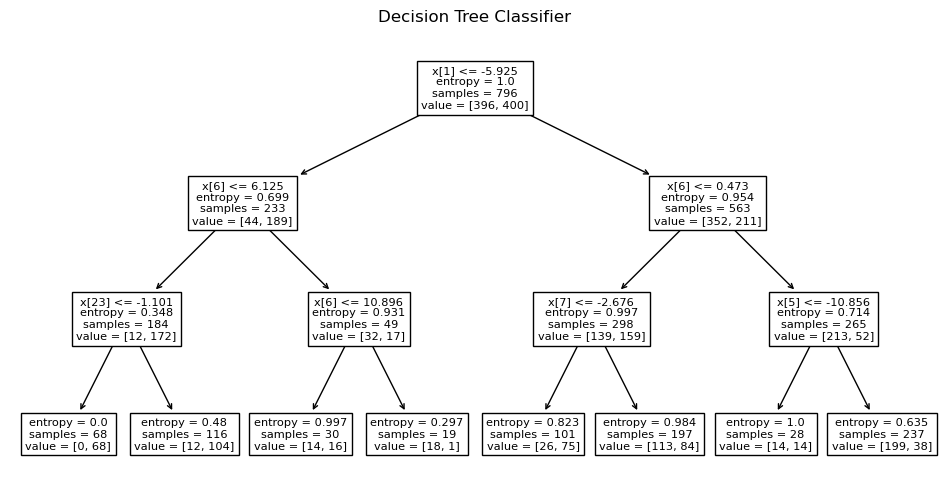

In [39]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
%matplotlib inline

tree_model.fit(X, y)
plt.figure(figsize=(12, 6))
plot_tree(tree_model)
plt.title("Decision Tree Classifier")
plt.show()

At each step in the tree, a question is asked about one of the independent variables, which are the components derived from PCA (e.g. `x[1] <= -5.925`) asks about whether component 1 is less than or equal to 5.925, and the tree decides which path to follow based on the answer. At each box, you can also see how many images from the training data would be on the path up to this point, and how many are in each class. For example, the second box in level 3 (with `x[6] <= 10.896`) is reached by 49 images, 32 of which are apples and 17 of which are oranges. The model aims to minimise `entropy` at each step, a measure of how much uncertainty remains (notice, for example, that entropy is at its maximum `1` in the first box, where half of the images are of each class, which is the worst possible situation, and is lower in the boxes where a large proportion of the images remaining are of one class).

Note: there is no immediate real-world meaning of the components `x`, since they are abstract constructs that come from PCA. It might be possible to work out what concepts are represented by the components by analysing how they came from the images' pixels, but that would be a large and laborious task.

When we set up the model, we specified a `max_depth` of `3`, meaning that the tree is only allowed to have three levels before a decision is made about the class. The maximum number of levels can be increased to allow for a more complex tree. However, we found that this does not increase the model's accuracy. More levels does not necessarily mean a better model, as the tree may simply overfit to small details in the training set if it has too many levels.

<h5>Random forests</h5>

Random forests are an extension of decision tree models. Trying to make trees have more information by increasing their depth can lead to overfitting, so random forests increase the amount of information they hold with a different approach. Many decision trees are created using different independent variables, and then each tree predicts the class of the unseen data, and the trees decide their final prediction together by voting. This allows for a well-informed prediction that uses all of the independent variables effectively, without the pitfall of high-depth trees overfitting to a small number of data points.

Let's fit a random forest with 100 random trees.

In [40]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=1)

random_forest_scores = cross_val_score(random_forest_model, X, y, cv=kf)

print("\nRANDOM FOREST")
print("Cross-validation scores:", random_forest_scores)
print("Mean accuracy:", random_forest_scores.mean())
print("Standard deviation:", random_forest_scores.std())


RANDOM FOREST
Cross-validation scores: [0.7625     0.74213836 0.79874214 0.81132075 0.7672956 ]
Mean accuracy: 0.7763993710691824
Standard deviation: 0.02517375636595397


This model does a lot better than the individual random tree, achieving a score of 77.6%, about the same as logistic regression (the difference is smaller than the standard deviation of the cross-validation scores, and is not statistically significant).

As with the number of levels in a single tree, the number of trees in the forest can be changed. We found that using 100 trees works just as effectively as using more, and there is no benefit to making the model more complex in this case. This is not surprising, since there are 50 PCA components, so 100 trees should be more than adequate for analysing them. (It is also possible to try to increase the number of PCA components and the number of trees to match. The author did not find that this significantly improved the performance of the model.)

<h5>Support Vector Machines</h5>

Support Vector Machines (or SVMs) plot the data in high-dimensional space, with one dimension for each independent variable (plus possibly extra dimensions, constructed from some extra variable made from a combination of the independent variables, if the model finds them helpful). The model will then try to fit a plane into the space such that the plane separates the classes, and then the classes of new data are predicted based on which side of the plane they fall into.

In [45]:
from sklearn.svm import LinearSVC

SVM_model = LinearSVC(class_weight='balanced', random_state=1, fit_intercept=False, max_iter = 5000, dual='auto')

SVM_scores = cross_val_score(SVM_model, X, y, cv=kf)
print("\nSUPPORT VECTOR MACHINES")
print("Cross-validation scores:", SVM_scores)
print("Mean accuracy:", SVM_scores.mean())
print("Standard deviation:", SVM_scores.std())


SUPPORT VECTOR MACHINES
Cross-validation scores: [0.775      0.76100629 0.77987421 0.81761006 0.74213836]
Mean accuracy: 0.775125786163522
Standard deviation: 0.024959997266620494


This model also achieves the same level of performance, with a prediction accuracy of 77.5%.

<h5>k-Nearest Neighbours</h5>

The final model we will build is a k-Nearest Neighbours (or 'KNN') model. Similarly to Support Vector Machines, KNN also plots the data points in high dimensional space. Then, the classes of new data are predicted by finding their `k` nearest neighbours (in terms of distance in space) and counting the most common class among them. The value of `k` can be specified in the model.

In [66]:
# Avoid Jupyter warnings about the number of phsyical cores.
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

KNN_model = KNeighborsClassifier(n_neighbors=6)

KNN_scores = cross_val_score(KNN_model, X.values, y, cv=kf)
print("\nK-NEAREST NEIGHBOURS")
print("Cross-validation scores:", KNN_scores)
print("Mean accuracy:", KNN_scores.mean())
print("Standard deviation:", KNN_scores.std())


K-NEAREST NEIGHBOURS
Cross-validation scores: [0.7125     0.72955975 0.75471698 0.78616352 0.77358491]
Mean accuracy: 0.7513050314465409
Standard deviation: 0.02720969077119854


This model's performance is only slightly weaker than those of Logistic Regression, Random Forests and Support Vector Machines, classifying 75.1% of the test data correctly. The difference in performance is slightly under one standard deviation of the cross-validation scores, so the differences are likely to be due to chance, and we cannot conclude which models are the best - only that the models probably have at least somewhat similar levels of performance.

As with the parameters of the previous models, the author did not find a significant difference in the results when the value of `k` was adjusted. `k = 6` gave the best results. Note however, that `k = 5`, for example, gives a result of 74%, not different by more than one standard deviation of the cross-validation scores. We can only conclude that numbers of neighbours around this are generally a good idea, but not which exact amount is the best.